In [1]:
import numpy as np
import random
from random import choices
import time
import operator
import copy
from collections import defaultdict
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [2]:
chromosome_length = 100
population_size = 250

In [3]:
def create_starting_population(individuals, chromosome_length):
    # Set up an initial array of all zeros
    population = np.zeros((individuals, chromosome_length))
    # Loop through each row (individual)
    for i in range(individuals):
        # Choose a random number of ones to create
        individual = np.array([])
        for j in range(chromosome_length):
            choice = choices([0,1])[0]
            individual = np.hstack((individual,choice))
        
        population[i] = individual
        # Shuffle row
        np.random.shuffle(population[i])

    return population

def calculate_fitness(population):
    # Counting-ones fitness evaluation
    fitness_scores = [np.sum(p) for p in population]
    return fitness_scores


def two_point_crossover(parent_1, parent_2):

    chromosome_length = len(parent_1)
    # Pick random crossover points
    crossover_point1 = random.randint(1,chromosome_length)
    crossover_point2 = random.randint(1,chromosome_length-1)

    if crossover_point2 < crossover_point1:
        crossover_point1, crossover_point2 = crossover_point2, crossover_point1

    # Create children by swapping bit string in between crossover points

    child_1 = np.hstack((parent_1[0:crossover_point1],
                        parent_2[crossover_point1:crossover_point2],
                        parent_1[crossover_point2:]))

    child_2 = np.hstack((parent_2[0:crossover_point1],
                        parent_1[crossover_point1:crossover_point2],
                        parent_2[crossover_point2:]))

    # Return children
    return child_1, child_2



def uniform_crossover(parent_1, parent_2):
    chromosome_length = len(parent_1)
    child_1 = np.array([])
    child_2 = np.array([])
    
    for i in range(chromosome_length):
        # drawn at random
        choice = choices([parent_1[i],parent_2[i]])[0]
        compare = choice==parent_1[i]
        if compare==True:
            child_1  = np.hstack((child_1,parent_1[i]))
            child_2  = np.hstack((child_2,parent_2[i]))
        else:
            child_1  = np.hstack((child_1,parent_2[i]))
            child_2  = np.hstack((child_2,parent_1[i]))
    # Return children
    return child_1, child_2


def check_stopping_criterion(fitness_values):
    parent1_fitness = fitness_values[0]
    parent2_fitness = fitness_values[1]
    child1_fitness = fitness_values[2]
    child2_fitness = fitness_values[3]

    # Find parent with highest fitness
    if(parent1_fitness > parent2_fitness):
        max_parent_fitness = parent1_fitness
    else:
        max_parent_fitness = parent2_fitness

    # Check if both children have lower fitness than the best parent
    if(child1_fitness <= max_parent_fitness and child2_fitness <= max_parent_fitness):
        # stopping criterion triggered
        return True

    else:
        return False

In [4]:
population = create_starting_population(int(population_size), chromosome_length)
num_bits = len(population)*len(population[0])

plot_dict = defaultdict(list)
prop = int(np.sum(population))/num_bits  
plot_dict[str(0)] = [prop,0,0,0,0,0,0,0,0]

In [5]:
def run_generation(population,crossover_operator):
    num_generation = 0
    while(True):
        #print(list(plot_dict.values())[-1])
        selection_errors = 0
        correct_selection_decisions = 0
        schema_zero = 0
        schema_one = 0
        schema_zero_array = np.array([]).reshape(0,100)
        schema_one_array = np.array([]).reshape(0,100)
        num_generation += 1
        #flag = 1
        population_size = len(population) 
        chromosome_length = len(population[0])
        # Create an empty list for new population
        new_population = np.array([]).reshape(0, chromosome_length)
        # Create new popualtion generating two children at a time
        for i in range(0,population_size-1,2):
            parent_1 = population[i]
            parent_2 = population[i+1]

            # Perform unifrom crossover
            if crossover_operator == 'UX':
                child_1, child_2 =  uniform_crossover(parent_1, parent_2)
            # Perform two-point crossover
            elif crossover_operator == '2X':
                child_1, child_2 = two_point_crossover(parent_1, parent_2)
            else:
                warnings.warn("Use '2X' for two-point crossover and 'UX' for uniform crossover")

           # Family of 4
            family = np.array([parent_1,parent_2,child_1,child_2])
 
            family_fitness = calculate_fitness(family)
            best_two = np.argsort(family_fitness)[::-1][:2]
            best_in_family = family[best_two]
            
            for q in range(chromosome_length):
                if parent_1[q]!=parent_2[q]:
                    if (best_in_family[0][q]==0 and best_in_family[1][q]==0):
                        selection_errors += 1
                    elif (best_in_family[0][q]==1 and best_in_family[1][q]==1):
                        correct_selection_decisions += 1
            #print(calculate_fitness(best_in_family))
            new_population =  np.vstack((new_population, best_in_family))    
        
        for num in range(len(population)):
            if(population[num][0]==0):
                schema_zero += 1
                schema_zero_array = np.vstack((schema_zero_array,population[num])) 
            else:
                schema_one += 1
                schema_one_array = np.vstack((schema_one_array,population[num]))
    
        avg_fitness_schema_zero = np.sum(calculate_fitness(schema_zero_array))/250
        avg_fitness_schema_one = np.sum(calculate_fitness(schema_one_array))/250
        
        std_schema_zero = np.std(schema_zero_array)
        std_schema_one = np.std(schema_one_array)
        # Replace the old population with the new one
        for k in new_population :
            np.random.shuffle(k)
        population = copy.deepcopy(new_population)
        new_population = np.array([]).reshape(0, chromosome_length)
        scores = calculate_fitness(population)  
        
        # Check if global optimum has been found    
        best_score = np.sum(scores)/250
        #print(num_generation,best_score)
        if(best_score==100):
            # Return number of generations and number of fitness function evaluations
            prop=1.0
            plot_dict[str(num_generation)] = [prop,selection_errors,correct_selection_decisions,schema_zero,schema_one,avg_fitness_schema_zero,avg_fitness_schema_one,std_schema_zero,std_schema_one]
            return num_generation
        
        prop = int(np.sum(population))/num_bits 
        plot_dict[str(num_generation)] = [prop,selection_errors,correct_selection_decisions,schema_zero,schema_one,avg_fitness_schema_zero,avg_fitness_schema_one,std_schema_zero,std_schema_one]

In [6]:
crossover_operator = 'UX'
outcome = run_generation(population, crossover_operator)

C:\Users\Rohit\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Rohit\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Rohit\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
num_gen = list(plot_dict.keys())
prop = np.array(list(plot_dict.values()))[:,0]
selection_error = np.array(list(plot_dict.values()))[:,1]
correct_selection_decision = np.array(list(plot_dict.values()))[:,2]
schema_zero = np.array(list(plot_dict.values()))[:,3]
schema_one = np.array(list(plot_dict.values()))[:,4]
avg_fitness_schema_zero = np.array(list(plot_dict.values()))[:,5]
avg_fitness_schema_one = np.array(list(plot_dict.values()))[:,6]
std_schema_zero = np.array(list(plot_dict.values()))[:,7]
std_schema_one = np.array(list(plot_dict.values()))[:,8]

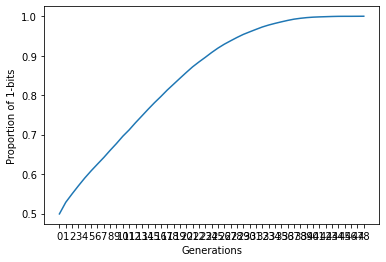

In [8]:
fig, ax = plt.subplots()
ax.plot(num_gen,prop)
ax.set_xlabel('Generations')
ax.set_ylabel('Proportion of 1-bits')
plt.show()

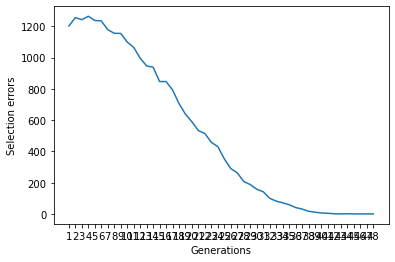

In [9]:
fig, ax = plt.subplots()
ax.plot(num_gen[1:],selection_error[1:])
ax.set_xlabel('Generations')
ax.set_ylabel('Selection errors')
plt.show()

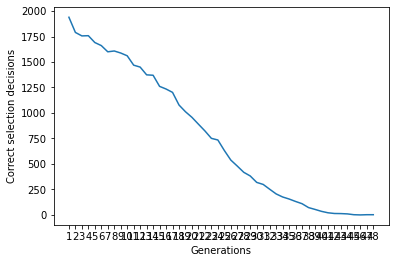

In [10]:
fig, ax = plt.subplots()
ax.plot(num_gen[1:],correct_selection_decision[1:])
ax.set_xlabel('Generations')
ax.set_ylabel('Correct selection decisions')
plt.show()

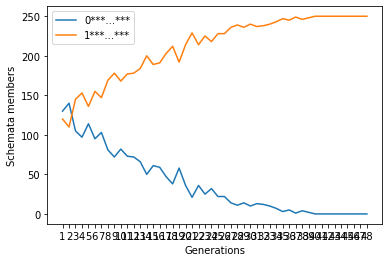

In [11]:
fig, ax = plt.subplots()
ax.plot(num_gen[1:],schema_zero[1:],label='0***...***')
ax.plot(num_gen[1:],schema_one[1:],label='1***...***')
ax.set_xlabel('Generations')
ax.set_ylabel('Schemata members')
plt.legend()
plt.show()

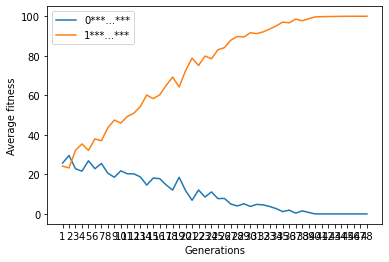

In [12]:
fig, ax = plt.subplots()
ax.plot(num_gen[1:],avg_fitness_schema_zero[1:],label='0***...***')
ax.plot(num_gen[1:],avg_fitness_schema_one[1:],label='1***...***')
ax.set_xlabel('Generations')
ax.set_ylabel('Average fitness')
plt.legend()
plt.show()

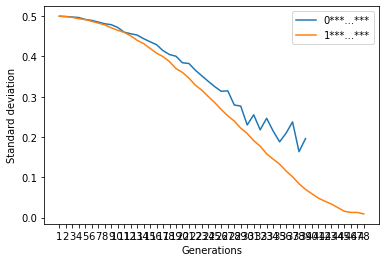

In [13]:
fig, ax = plt.subplots()
ax.plot(num_gen[1:],std_schema_zero[1:],label='0***...***')
ax.plot(num_gen[1:],std_schema_one[1:],label='1***...***')
ax.set_xlabel('Generations')
ax.set_ylabel('Standard deviation')
plt.legend()
plt.show()